In [1]:
from peft import LoraConfig, TaskType, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch as t
import einops
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import copy

device = "cuda" if t.cuda.is_available() else "cpu"
model_name = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=t.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_storage=t.bfloat16,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=t.bfloat16,
    device_map=device,
    trust_remote_code=True,
    attn_implementation="eager"
)

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=512,
    lora_alpha=16,
    target_modules="all-linear",
    use_rslora=True,
)

lora_model = copy.deepcopy(base_model)
lora_model = get_peft_model(lora_model, lora_config)
lora_model.print_trainable_parameters()

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.add_special_tokens({'bos_token': '<|startoftext|>'})
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

print(f"{tokenizer.bos_token_id = }")
print(f"{tokenizer.pad_token_id = }")
print(f"{tokenizer.eos_token_id = }")
print(f"{tokenizer.all_special_tokens = }")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


trainable params: 754,974,720 || all params: 3,534,658,560 || trainable%: 21.359197987145894
tokenizer.bos_token_id = 50295
tokenizer.pad_token_id = 50296
tokenizer.eos_token_id = 50256
tokenizer.all_special_tokens = ['<|startoftext|>', '<|endoftext|>', '<|pad|>']


In [2]:
def tokenize(prompt, **kwargs):
    return tokenizer(prompt, return_tensors="pt", padding=True, **kwargs).to(device)

def get_mask(token_ids: t.Tensor,):
    is_not_pad = (token_ids[:, :] != tokenizer.pad_token_id).bool()
    
    is_eos = (token_ids[:, :] == tokenizer.eos_token_id)
    is_eos = (is_eos.cumsum(dim=-1) >= 1).bool()
    is_not_eos = ~is_eos

    mask = is_not_pad & is_not_eos

    return mask.int()


In [3]:
number_token_ids = tokenizer.batch_encode_plus([f" {n}" for n in range(1, 101)], add_special_tokens=False).input_ids
number_token_ids = t.Tensor(number_token_ids).flatten().long().to(device)

def get_match(token_ids):
    match = (token_ids.unsqueeze(-1) == number_token_ids).int()
    match_ = match.argmax(-1) + 1
    match_[~match.any(-1)] = 0
    match_ = match_[match_ > 0]

    return match_.cpu()

len(number_token_ids), number_token_ids



(100,
 tensor([  352,   362,   513,   604,   642,   718,   767,   807,   860,   838,
          1367,  1105,  1511,  1478,  1315,  1467,  1596,  1248,   678,  1160,
          2310,  2534,  2242,  1987,  1679,  2608,  2681,  2579,  2808,  1542,
          3261,  3933,  4747,  4974,  3439,  4570,  5214,  4353,  5014,  2319,
          6073,  5433,  5946,  5846,  4153,  6337,  6298,  4764,  5125,  2026,
          6885,  6740,  7192,  7175,  5996,  7265,  7632,  7618,  7863,  3126,
          8454,  8190,  8093,  5598,  6135,  7930,  8275,  8257,  8644,  4317,
          9166,  7724,  8854,  8915,  5441,  8684,  8541,  8699,  9225,  4019,
          9773,  9415,  9698,  9508,  7600,  9849, 10083,  9193,  9919,  4101,
         10495, 10190, 10261, 10048,  6957,  9907, 10111,  9661,  7388,  1802],
        device='cuda:0'))

len(match) = 87


[]

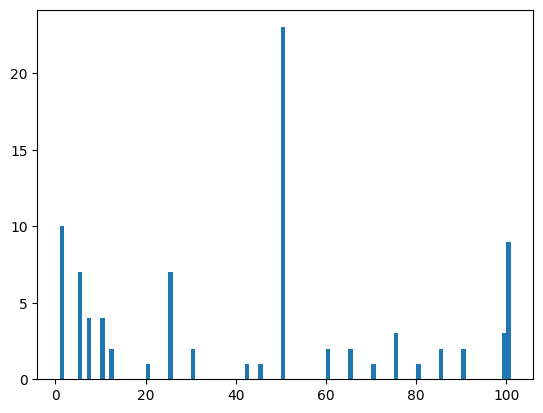

In [4]:
prompt_token_ids = tokenize(["Choose a number between 1 and 100:"]).input_ids
prompt_masks = get_mask(prompt_token_ids)

with t.inference_mode():
    token_ids = lora_model.generate(
        input_ids=prompt_token_ids,
        attention_mask=prompt_masks,
        max_new_tokens=1,
        num_return_sequences=1000,
        do_sample=True,
        temperature=1,
        bos_token_id=tokenizer.bos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

match = get_match(token_ids[:, -1])
print(f"{len(match) = }")

plt.hist(match.cpu().numpy(), bins=100, range=(1, 101))
plt.plot()


In [5]:
def calc_log_rewards(
    token_ids: t.Tensor, # [n_sentences, n_tokens]
) -> t.Tensor: # [n_sentences]

    log_rewards = t.full(token_ids.shape, fill_value=-16).to(device)

    first_token_mask = (
        (token_ids[:, 0].unsqueeze(-1) == number_token_ids)
        .any(dim=-1)
    )
    
    log_rewards[first_token_mask, 0] = 0

    return log_rewards


In [6]:
def calc_log_probs(model, token_ids: t.Tensor, temperature: float = 1):
    assert temperature > 0

    n_sentences, n_tokens = token_ids.shape
    attention_mask = get_mask(token_ids)

    outputs = model(input_ids=token_ids, attention_mask=attention_mask)

    logits = outputs.logits ** 1/temperature
    
    log_probs = logits[:, :-1].log_softmax(dim=-1).gather(2, token_ids[:, 1:, None])
    log_probs = log_probs.squeeze(dim=1).squeeze(2) * attention_mask[:, :-1]

    return log_probs


In [7]:
with t.no_grad():
    base_number_logits = base_model(prompt_token_ids).logits[0, -1]
    base_number_logits = base_number_logits[number_token_ids]

def calc_kl_div():
    base_model_dist = t.distributions.Categorical(logits=base_number_logits)

    with t.no_grad():
        lora_number_logits = lora_model(prompt_token_ids).logits[0, -1]
        lora_number_logits = lora_number_logits[number_token_ids]

    lora_model_dist = t.distributions.Categorical(logits=lora_number_logits)

    return t.distributions.kl_divergence(base_model_dist, lora_model_dist).item()



In [8]:
log_Z = t.tensor(1.0, requires_grad=True)

optimizer_lora = t.optim.AdamW([
    *[v for k, v in lora_model.named_parameters() if "lora" in k],
], lr=0.00001)

optimizer_Z = t.optim.AdamW([
    log_Z
], lr=0.1)

metrics_list = []


In [9]:
import copy
from random import choices

n_sentences = 500
max_len = 1

lora_model_copy = copy.deepcopy(lora_model)
lora_model.train()

for epoch in range(250):
    optimizer_lora.zero_grad()
    optimizer_Z.zero_grad()

    with t.no_grad():
        token_ids = lora_model_copy.generate(
            input_ids=prompt_token_ids,
            attention_mask=prompt_masks,
            max_new_tokens=max_len,
            num_return_sequences=n_sentences,
            do_sample=True,
            temperature=1,
            bos_token_id=tokenizer.bos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        log_rewards = calc_log_rewards(
            token_ids=token_ids[:, -1:],
        )

        log_probs = calc_log_probs(
            base_model,
            token_ids=token_ids,
            temperature=1,
        )[:, -max_len:].sum(-1)

    log_pF = calc_log_probs(
        lora_model,
        token_ids=token_ids,
        temperature=1,
    )[:, -max_len:].sum(-1)

    loss = (log_Z + log_pF - (log_rewards + log_probs)) ** 2
    loss = loss.mean()

    loss.backward()
    optimizer_lora.step()
    optimizer_Z.step()
    

    with t.inference_mode():
        test_token_ids = lora_model.generate(
            input_ids=prompt_token_ids,
            attention_mask=prompt_masks,
            max_new_tokens=max_len,
            num_return_sequences=1000,
            do_sample=True,
            temperature=1,
            bos_token_id=tokenizer.bos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    loss_metric = loss.item()
    
    test_match = get_match(test_token_ids[:, -1])
    test_match_ratio_metric = len(test_match) / 1000

    Z_metric = log_Z.exp().item()

    kl_div_metric = calc_kl_div()

    print(f"{epoch:02d}, loss = {loss_metric:.3f} | match r. = {test_match_ratio_metric:.3f} | Z = {Z_metric:.3f} | KL = {kl_div_metric:.3f}")
    metrics_list.append((loss_metric, test_match_ratio_metric, Z_metric, kl_div_metric))
    
    if (epoch + 1) % 10 == 0:
        print("Updating model")
        lora_model_copy = copy.deepcopy(lora_model)



00, loss = 260.565 | match r. = 0.155 | Z = 2.457 | KL = 0.128
01, loss = 256.643 | match r. = 0.291 | Z = 2.221 | KL = 0.147
02, loss = 241.999 | match r. = 0.493 | Z = 2.009 | KL = 0.123
03, loss = 215.565 | match r. = 0.659 | Z = 1.817 | KL = 0.225
04, loss = 179.432 | match r. = 0.809 | Z = 1.646 | KL = 0.223
05, loss = 141.909 | match r. = 0.903 | Z = 1.493 | KL = 0.324
06, loss = 105.224 | match r. = 0.968 | Z = 1.358 | KL = 0.512
07, loss = 75.505 | match r. = 0.989 | Z = 1.239 | KL = 0.393
08, loss = 71.572 | match r. = 0.997 | Z = 1.137 | KL = 0.497
09, loss = 53.074 | match r. = 0.999 | Z = 1.049 | KL = 0.425
Updating model
10, loss = 6.783 | match r. = 1.000 | Z = 0.973 | KL = 0.589
11, loss = 6.496 | match r. = 1.000 | Z = 0.906 | KL = 0.485
12, loss = 6.208 | match r. = 1.000 | Z = 0.848 | KL = 0.594
13, loss = 6.472 | match r. = 1.000 | Z = 0.796 | KL = 0.878
14, loss = 5.914 | match r. = 1.000 | Z = 0.750 | KL = 1.006
15, loss = 5.410 | match r. = 1.000 | Z = 0.708 | KL 

[]

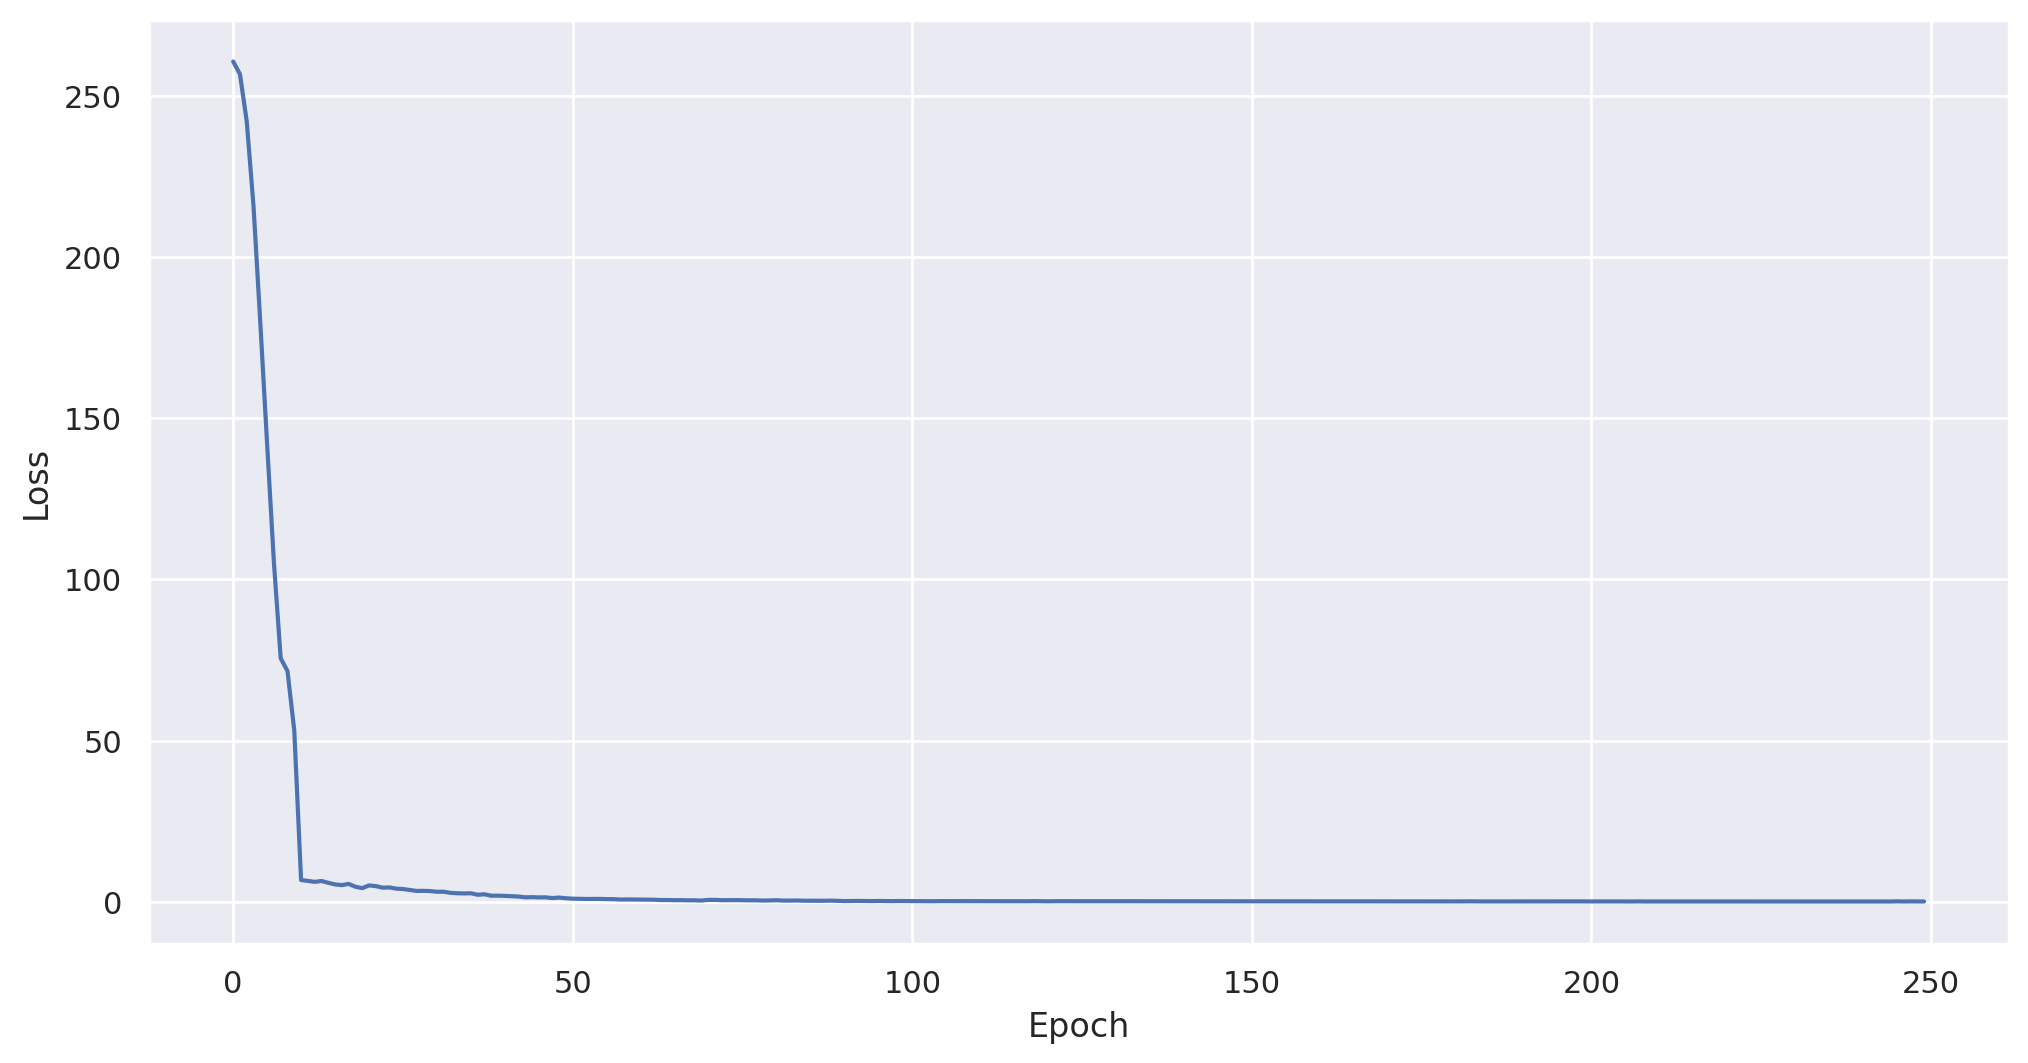

In [28]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

sns.lineplot(
    list(map(lambda x: x[0], metrics_list)),
    ax=ax,
)

ax.set(xlabel='Epoch',
       ylabel='Loss')

fig.set_dpi(200)
plt.plot()

[]

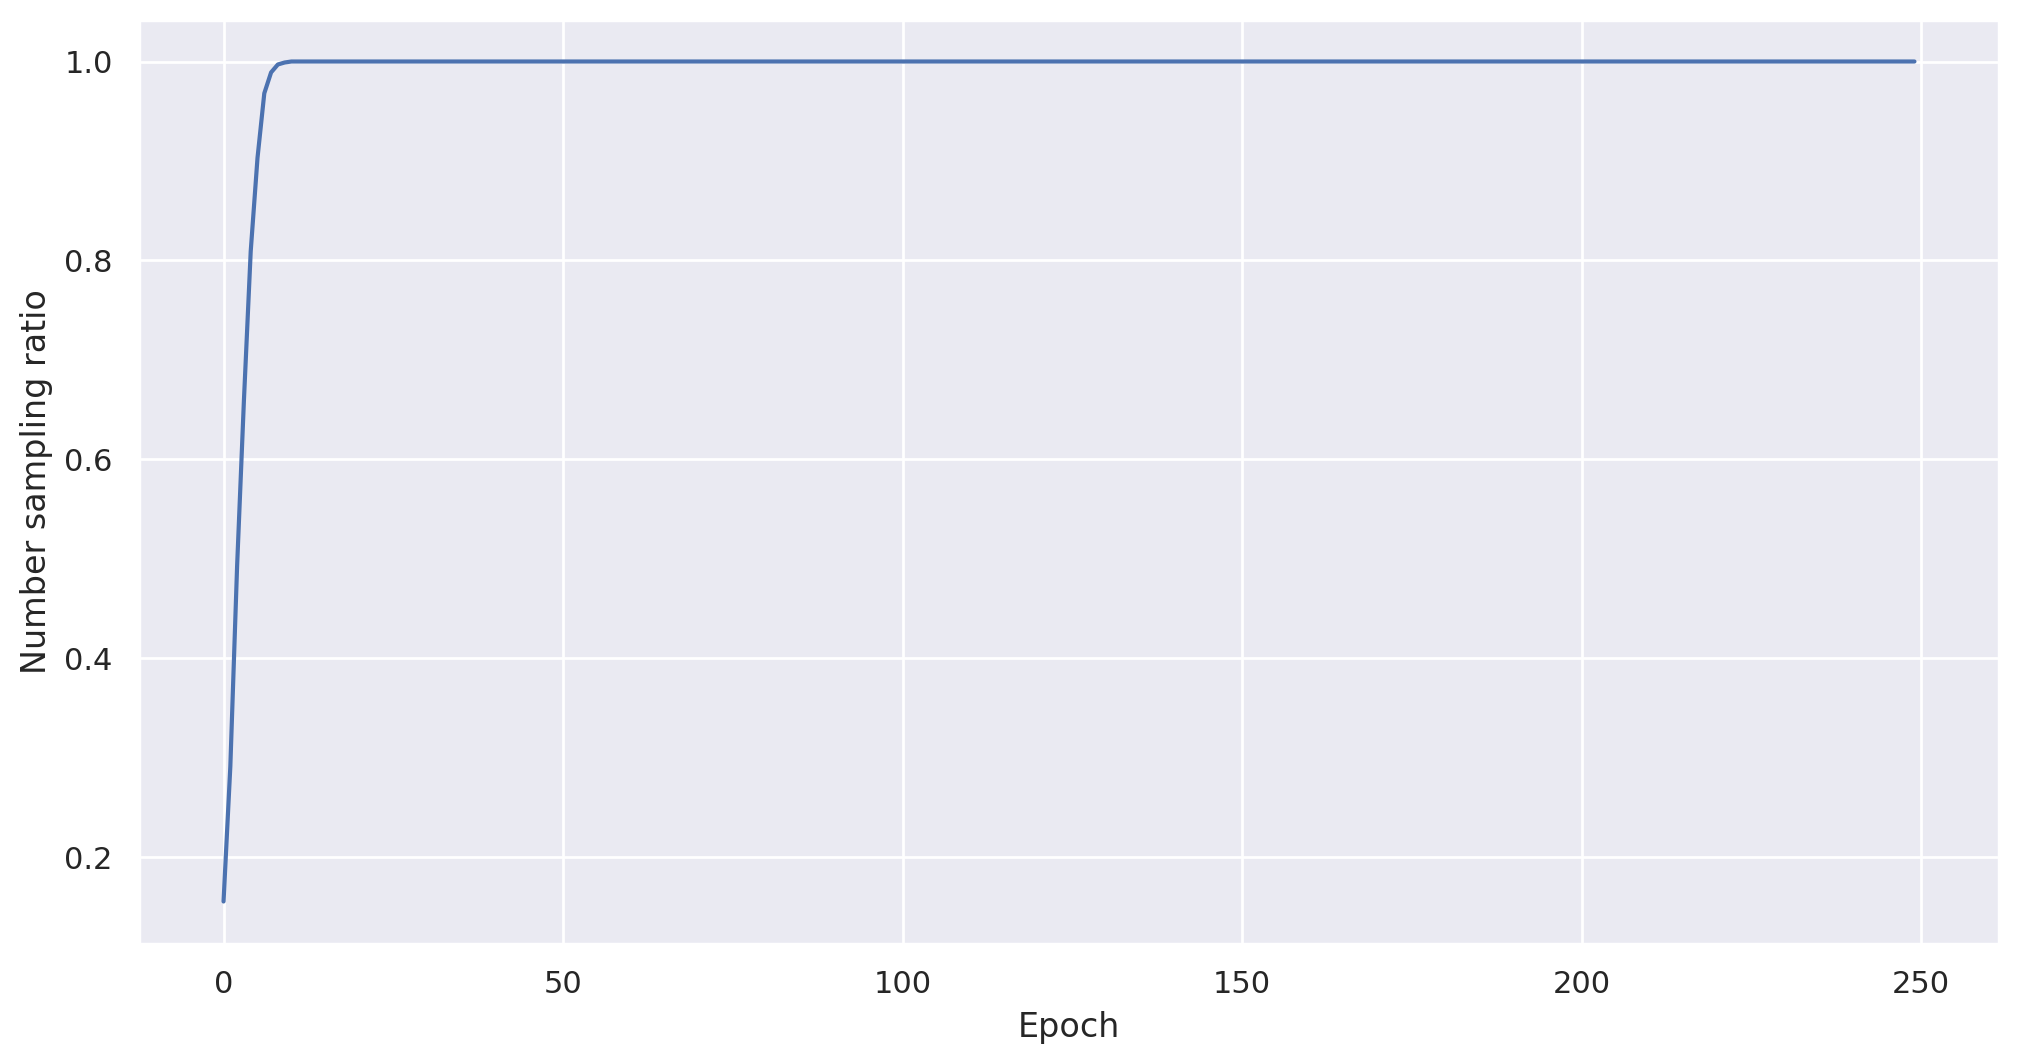

In [32]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

sns.lineplot(
    list(map(lambda x: x[1], metrics_list)),
    ax=ax,
)

ax.set(xlabel='Epoch',
       ylabel='Number sampling ratio')

fig.set_dpi(200)
plt.plot()

[]

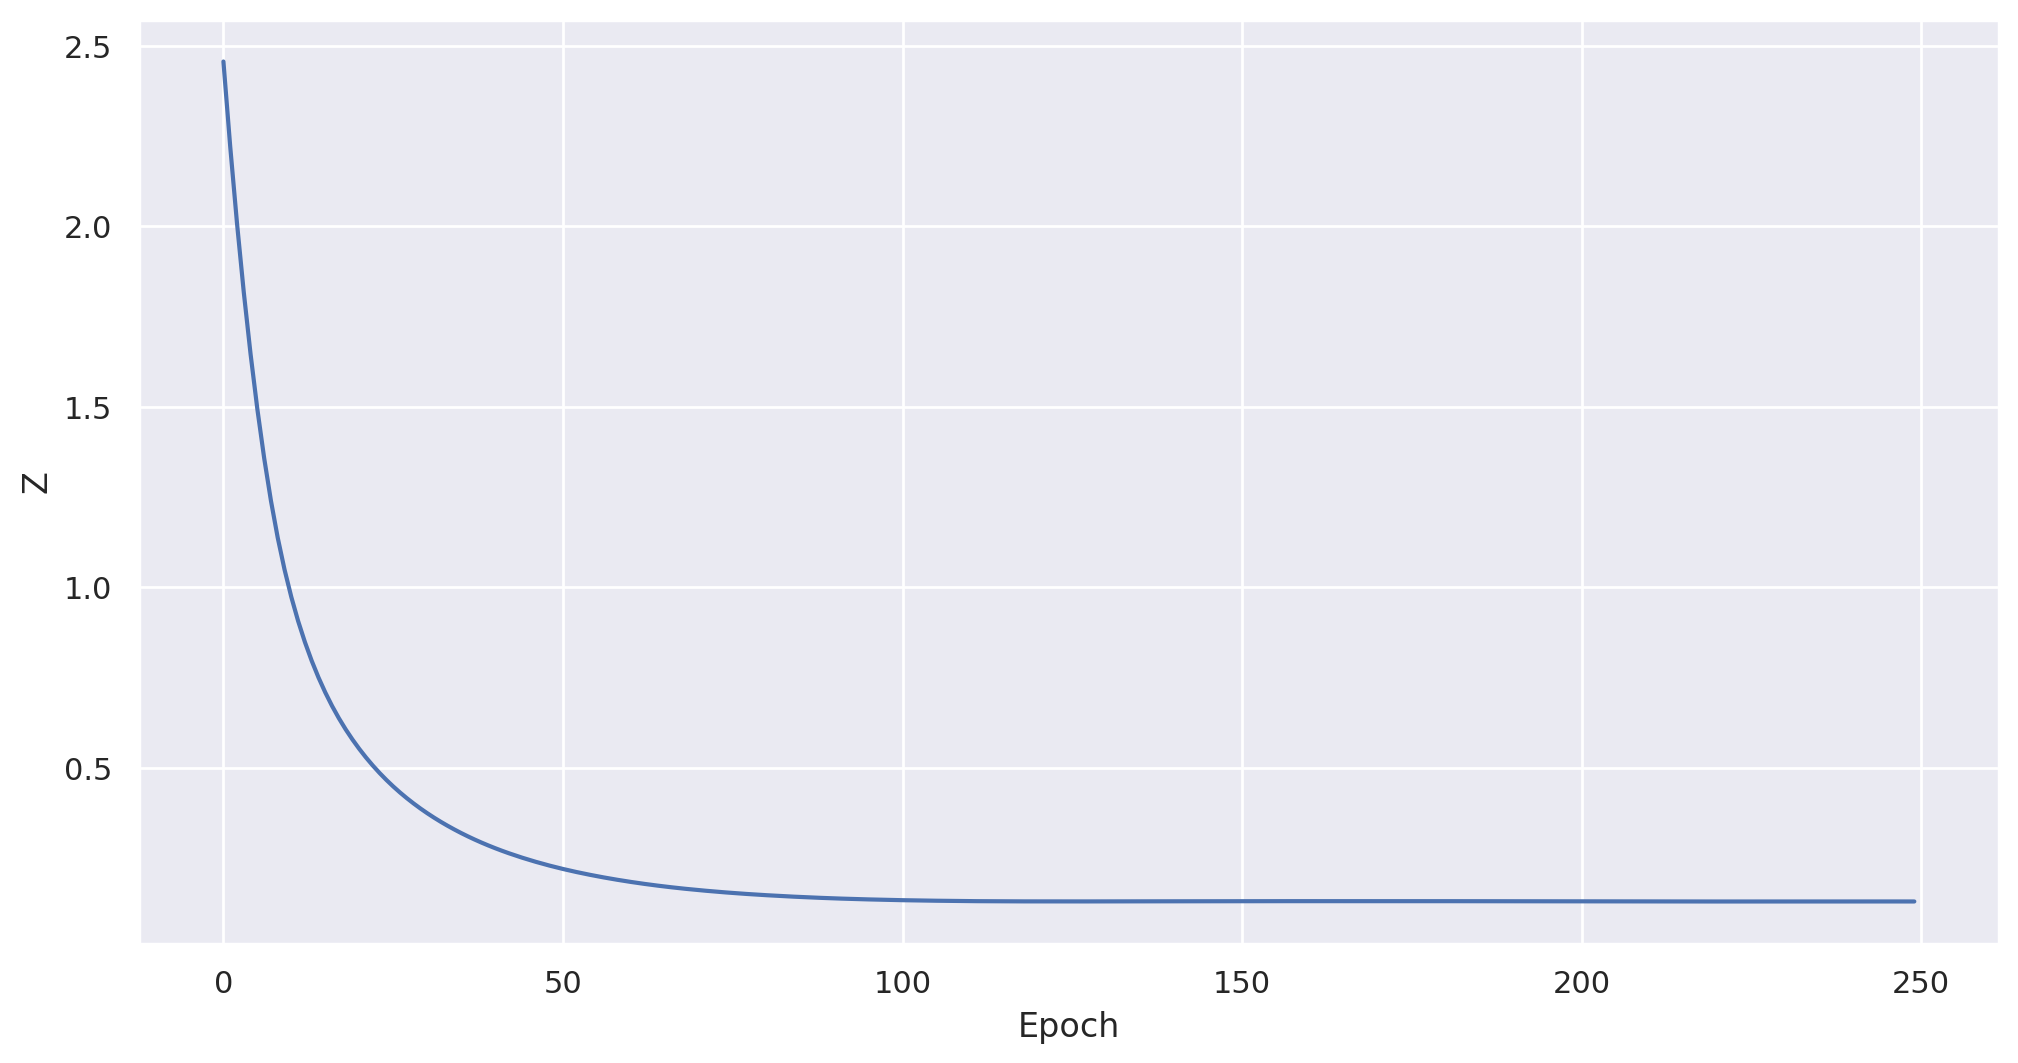

In [30]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

sns.lineplot(
    list(map(lambda x: x[2], metrics_list)),
    ax=ax,
)

ax.set(xlabel='Epoch',
       ylabel='Z')

fig.set_dpi(200)
plt.plot()

[]

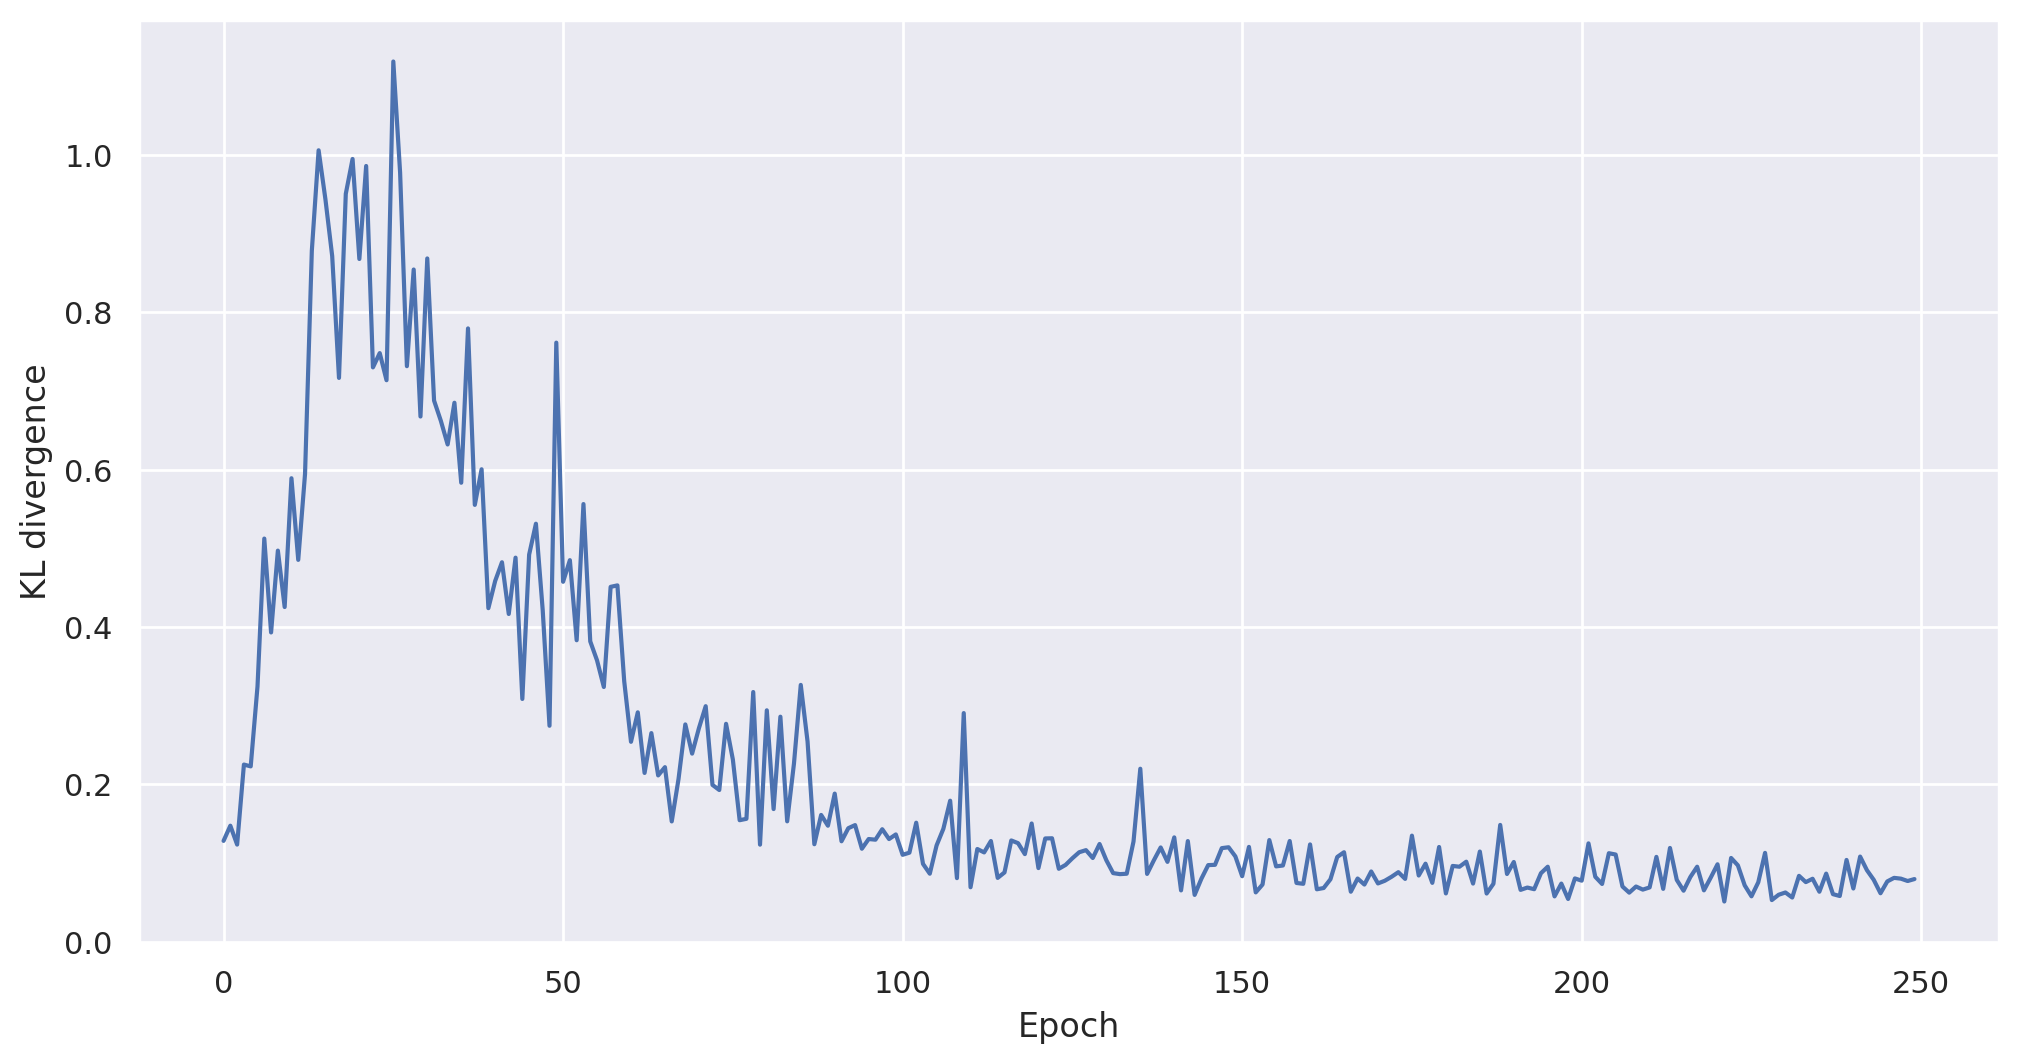

In [31]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

sns.lineplot(
    list(map(lambda x: x[3], metrics_list)),
    ax=ax,
)

ax.set(xlabel='Epoch',
       ylabel='KL divergence')

fig.set_dpi(200)
plt.plot()

len(match) = 500


[]

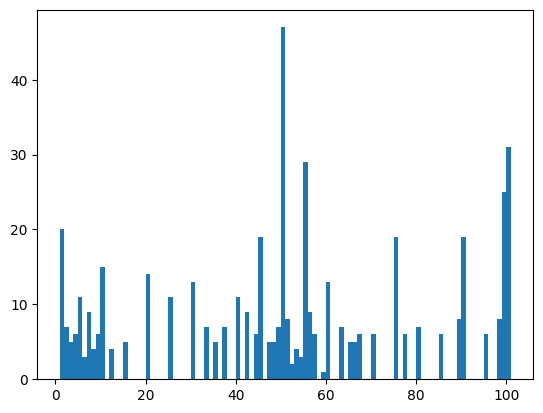

In [20]:
lora_model.eval()

with t.inference_mode():
    token_ids = lora_model.generate(
        input_ids=prompt_token_ids,
        attention_mask=prompt_masks,
        max_new_tokens=max_len,
        num_return_sequences=n_sentences,
        do_sample=True,
        temperature=1,
        bos_token_id=tokenizer.bos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

match = get_match(token_ids[:, -1])
print(f"{len(match) = }")

plt.hist(match.cpu().numpy(), bins=100, range=(1, 101))
plt.plot()